In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fsspec
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import Literal
from dataclasses import dataclass, field
from collections import defaultdict
from graphium.utils import fs

In [3]:
ROOT_DIR = "gs://graphium-private/pretrained-models/ToyMix/cas"

PT_TASKS = ["qm9", "tox21", "zinc"]
PT_FT_RELS = {
    "toymix_gcn_1": {"caco2": "finetuning_caco2_wang_gcn_1", "lipophilicity": "finetuning_lipophilicity_astrazeneca_gcn_1"},
    "toymix_gcn_2": {"caco2": "finetuning_caco2_wang_gcn_2", "lipophilicity": "finetuning_lipophilicity_astrazeneca_gcn_2"},
}
FT_METRICS = {"caco2": "graph_caco2_wang/mae/test", "lipophilicity": "graph_lipophilicity_astrazeneca/r2_score/test"}

In [4]:
@dataclass
class FinetuningResult: 
    name: str
    scores: dict[str, list[float]] = field(default_factory=lambda: defaultdict(list))

    def best(self, metric, minimize: bool = False):
        return max(self.scores[metric]) if not minimize else min(self.scores[metric])


@dataclass
class PretrainingResult: 
    name: str
    loss: dict[Literal["qm9", "zinc", "tox21", "all"], float] = field(default_factory=dict)
    ft_results: dict[str, FinetuningResult] = field(default_factory=dict)

    @property
    def finetuning_tasks(self):
        return sorted(list(self.ft_results.keys()))

In [5]:
globber, _ = fsspec.core.url_to_fs(ROOT_DIR)

results = {}

for pt_dir, ft_dirs in tqdm(PT_FT_RELS.items()):
    
    # Create a new results object
    results[pt_dir] = PretrainingResult(name=pt_dir)

    # Parse the pre-training results
    pt_results_path = fs.join(ROOT_DIR, pt_dir, "results", "test_results.yaml")
    with fsspec.open(pt_results_path, "r") as f:
        pt_results = yaml.safe_load(f)
    results[pt_dir].loss = {k: pt_results[f"graph_{k}/loss/test"] for k in PT_TASKS}
    results[pt_dir].loss["all"] = pt_results["loss/test"]

    # Parse the associated fine-tuning results
    for ft_label, ft_dir in ft_dirs.items():

        # Create a new results object
        ft_results = FinetuningResult(name=ft_label)
        
        # Find all results for all trials
        ft_results_pattern = fs.join(ROOT_DIR, ft_dir, "**", "test_results.yaml")
        paths = globber.glob(ft_results_pattern)

        # Save all scores
        for path in paths: 
            with globber.open(path, "r") as f:
                data = yaml.safe_load(f)
            for k, v in data.items():
                ft_results.scores[k].append(v)
        
        # Save the finetuning results to the pre-training results
        results[pt_dir].ft_results[ft_label] = ft_results

            

/Users/cas.wognum/micromamba/envs/graphium/lib/python3.10/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
100%|██████████| 2/2 [00:20<00:00, 10.05s/it]


In [6]:
def draw_boxplot(results: dict[str, FinetuningResult], fine_tuning_task: str,  metric_label: str = None, loss_label: str = "all", ax=None):
    if ax is None: 
        _, ax = plt.subplots()
    if metric_label is None:
        metric_label = FT_METRICS[fine_tuning_task]
    for pt_label, pt_results in results.items():
        positions = [round(pt_results.loss[loss_label], 3)]
        data = pt_results.ft_results[fine_tuning_task].scores[metric_label]
        ax.boxplot(data, positions=positions)
    ax.set_xlabel(f"Pre-training loss on {loss_label}")
    ax.set_ylabel(metric_label)   

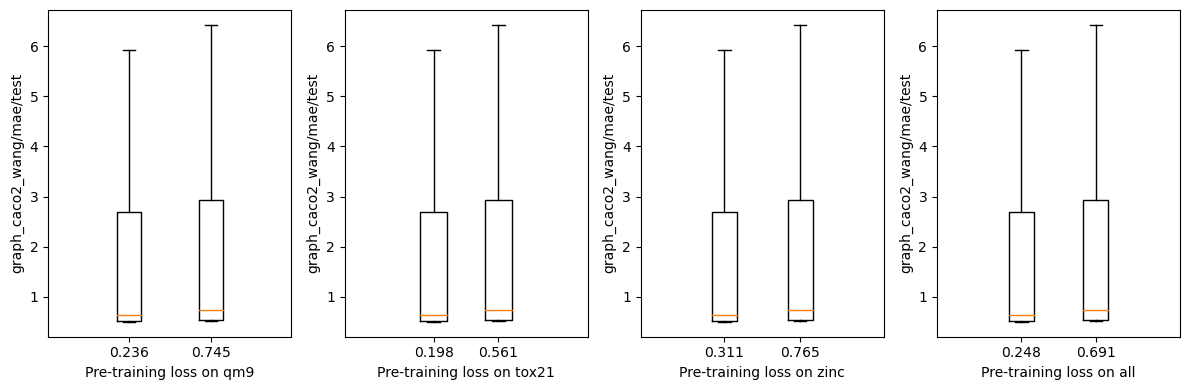

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, loss_label in enumerate(PT_TASKS + ["all"]):
    draw_boxplot(results, "caco2", loss_label=loss_label, ax=axs[i])
plt.tight_layout()

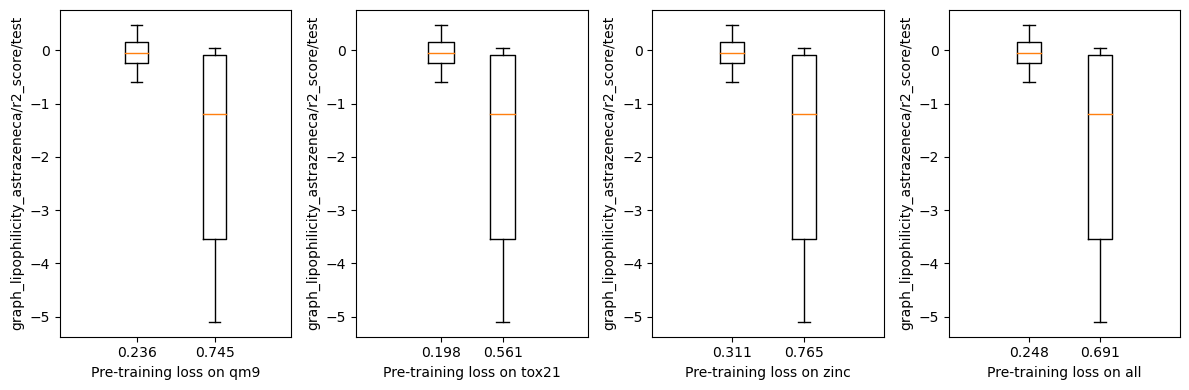

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, loss_label in enumerate(PT_TASKS + ["all"]):
    draw_boxplot(results, "lipophilicity", loss_label=loss_label, ax=axs[i])
plt.tight_layout()

In [9]:
cols = sorted(list(results.keys()))

rows = set()
for k in cols: 
    rows.update(results[k].ft_results.keys())
rows = sorted(list(rows))

data = pd.DataFrame(columns=cols, index=rows, dtype=float)

for pt_label, pt_results in results.items(): 
    for ft_label, ft_results in pt_results.ft_results.items(): 
        data.loc[ft_label, pt_label] = ft_results.best(FT_METRICS[ft_label], minimize="mae" in FT_METRICS[ft_label])

data

,toymix_gcn_1,toymix_gcn_2
caco2,0.502565,0.523741
lipophilicity,0.478970,0.041120


<Axes: >

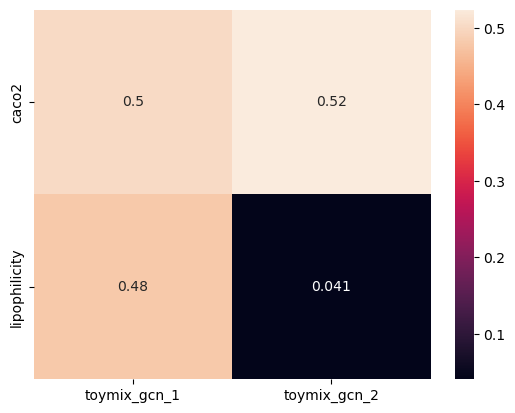

In [10]:
sns.heatmap(data, annot=True)

The End.